In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns

In [2]:
data = pd.read_csv('./tmdb_movies_cleaned.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9953 entries, 0 to 9952
Data columns (total 49 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          9953 non-null   int64  
 1   title                       9953 non-null   object 
 2   runtime                     9953 non-null   int64  
 3   release_date                9953 non-null   object 
 4   budget                      9953 non-null   int64  
 5   revenue                     9953 non-null   int64  
 6   popularity                  9953 non-null   float64
 7   vote_average                9953 non-null   float64
 8   vote_count                  9953 non-null   int64  
 9   belongs_to_collection       9953 non-null   int64  
 10  missingness_score           9953 non-null   int64  
 11  has_tagline                 9953 non-null   int64  
 12  has_homepage                9953 non-null   int64  
 13  num_same_title              9953 

In [4]:
def extract_nonbinary_numerical_features(df: pd.DataFrame) -> pd.DataFrame:
    numeric_df = df.select_dtypes(include=[np.number])
    nonbinary_df = numeric_df.loc[:, ~numeric_df.apply(lambda col: set(col.dropna().unique()) <= {0, 1})]

    return nonbinary_df
non_binnary_df = extract_nonbinary_numerical_features(data)


In [5]:
non_binnary_df.info()
non_binnary_df = non_binnary_df.drop(columns=['id', 'release_year', 'popularity_percentile'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9953 entries, 0 to 9952
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          9953 non-null   int64  
 1   runtime                     9953 non-null   int64  
 2   budget                      9953 non-null   int64  
 3   revenue                     9953 non-null   int64  
 4   popularity                  9953 non-null   float64
 5   vote_average                9953 non-null   float64
 6   vote_count                  9953 non-null   int64  
 7   num_same_title              9953 non-null   int64  
 8   num_genres                  9953 non-null   int64  
 9   num_production_companies    9953 non-null   int64  
 10  num_production_countries    9953 non-null   int64  
 11  num_spoken_languages        9953 non-null   int64  
 12  popularity_percentile       9953 non-null   float64
 13  weighted_rating             9953 

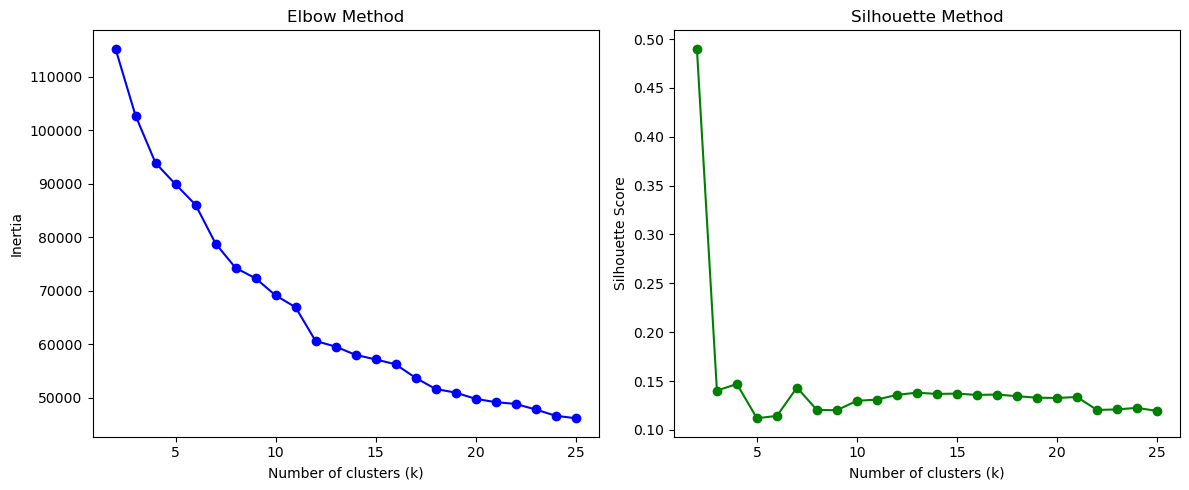

2

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

def tune_kmeans_clusters(data: pd.DataFrame, max_k: int = 25, random_state: int = 42, max_iter: int = 1000):
    """
    Finds the optimal number of KMeans clusters using the Elbow and Silhouette methods.

    Parameters:
    - data: pandas.DataFrame, the input data.
    - max_k: int, maximum number of clusters to try (default is 10).
    - random_state: int, random state for reproducibility.

    Returns:
    - best_k: int, optimal number of clusters based on silhouette score.
    - results: dict with inertia and silhouette scores for each k.
    """

    # Scale the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)

    inertia = []
    silhouette_scores = []

    k_values = list(range(2, max_k + 1))

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=random_state, max_iter=max_iter)
        kmeans.fit(scaled_data)
        inertia.append(kmeans.inertia_)
        score = silhouette_score(scaled_data, kmeans.labels_)
        silhouette_scores.append(score)

    # Plot Inertia (Elbow Method)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(k_values, inertia, 'bo-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Method')

    # Plot Silhouette Scores
    plt.subplot(1, 2, 2)
    plt.plot(k_values, silhouette_scores, 'go-')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Method')

    plt.tight_layout()
    plt.show()

    # Get best k based on silhouette score
    best_k = k_values[silhouette_scores.index(max(silhouette_scores))]

    return best_k
tune_kmeans_clusters(non_binnary_df)


### Using the elbow-method and with a bit corrolation with the sil-score it looks like the ideal cluster-number is around 12

In [7]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(non_binnary_df)


non_binnary_df["KMeans_Cluster"] = KMeans(n_clusters=12, random_state=42, max_iter=1000).fit_predict(scaled_data)

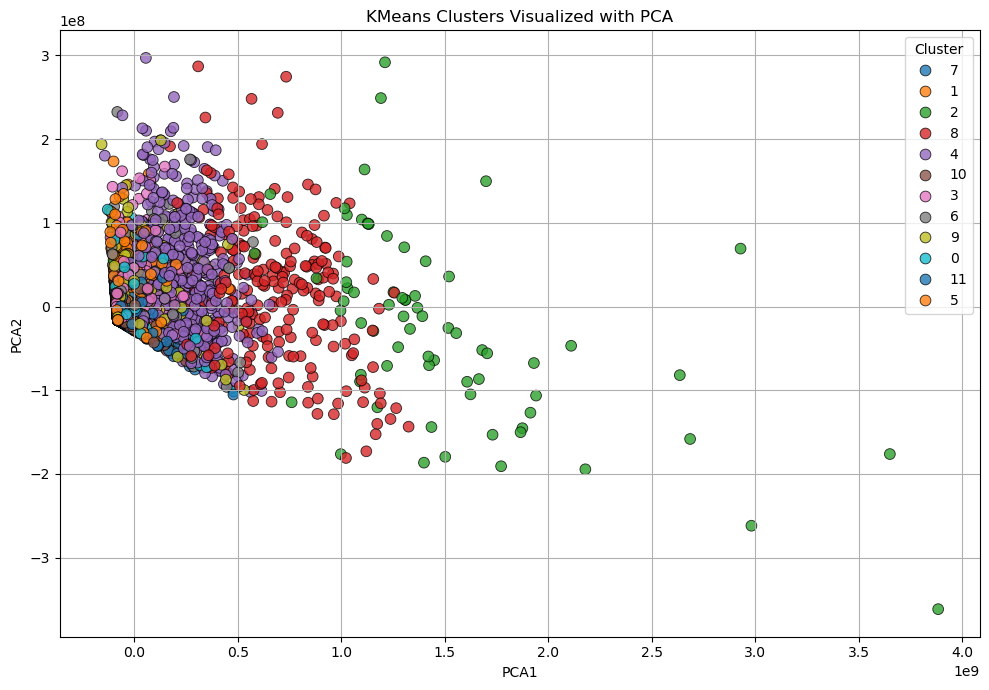

In [8]:
def plot_kmeans_clusters_2d(data, features, cluster_col='KMeans_Cluster'):
    """
    Reduces the data to 2D using PCA and visualizes KMeans clusters.

    Parameters:
    - data: pandas.DataFrame with the clustering result column.
    - features: list of feature column names used for clustering.
    - cluster_col: name of the column that stores the cluster labels (default is 'KMeans_Cluster').
    """
    # Apply PCA to reduce dimensions to 2D
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(data[features])

    # Create a temp DataFrame for plotting
    plot_df = pd.DataFrame({
        'PCA1': reduced[:, 0],
        'PCA2': reduced[:, 1],
        cluster_col: data[cluster_col].astype(str)  # convert to str for color separation
    })

    # Plot with seaborn
    plt.figure(figsize=(10, 7))
    sns.scatterplot(
        data=plot_df,
        x='PCA1', y='PCA2',
        hue=cluster_col,
        palette='tab10',
        s=60,
        alpha=0.8,
        edgecolor='k'
    )
    plt.title('KMeans Clusters Visualized with PCA')
    plt.legend(title='Cluster')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
plot_kmeans_clusters_2d(non_binnary_df, non_binnary_df.columns, cluster_col='KMeans_Cluster')

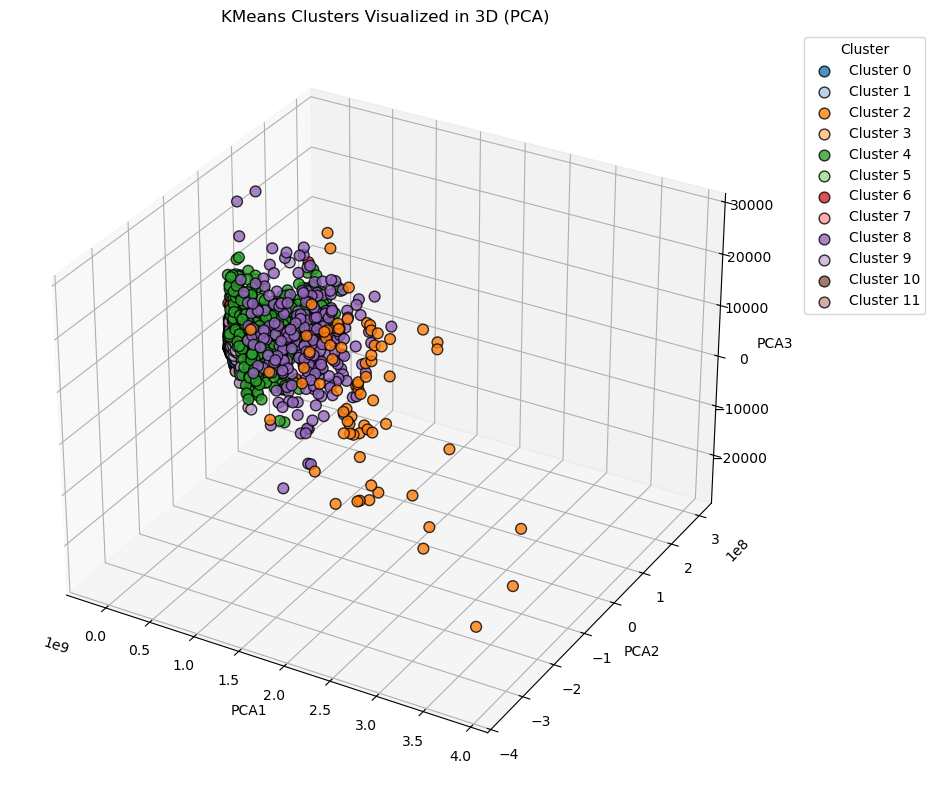

In [9]:
def plot_kmeans_clusters_3d(data, features, cluster_col='KMeans_Cluster'):
    """
    Visualizes KMeans clusters in 3D using PCA for dimensionality reduction.

    Parameters:
    - data: pandas.DataFrame that contains the clustering result column.
    - features: list of column names used as input for clustering.
    - cluster_col: name of the column that stores the cluster labels (default: 'KMeans_Cluster')
    """
    # Apply PCA to reduce to 3D
    pca = PCA(n_components=3)
    reduced = pca.fit_transform(data[features])

    # Prepare the 3D scatter plot
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    plot_df = pd.DataFrame(reduced, columns=['PCA1', 'PCA2', 'PCA3'])
    plot_df[cluster_col] = data[cluster_col].astype(str)  # for categorical coloring

    # Define a color palette with enough distinct colors
    unique_clusters = sorted(data[cluster_col].unique())
    palette = sns.color_palette("tab20", len(unique_clusters))
    color_map = dict(zip(map(str, unique_clusters), palette))

    # Plot each cluster
    for cluster in unique_clusters:
        cluster_data = plot_df[plot_df[cluster_col] == str(cluster)]
        ax.scatter(
            cluster_data['PCA1'],
            cluster_data['PCA2'],
            cluster_data['PCA3'],
            s=60,
            label=f'Cluster {cluster}',
            color=color_map[str(cluster)],
            edgecolor='k',
            alpha=0.8
        )

    ax.set_xlabel("PCA1")
    ax.set_ylabel("PCA2")
    ax.set_zlabel("PCA3")
    ax.set_title("KMeans Clusters Visualized in 3D (PCA)")
    ax.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
plot_kmeans_clusters_3d(non_binnary_df, non_binnary_df.columns, cluster_col='KMeans_Cluster')